In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

import pickle


In [2]:
#Read in data from CSV files.
df = pd.read_csv('raw_data/PO_Dataset.csv')
name_mapping = pd.read_csv('clean_data/Clean_Code_Master_list.csv')

#Check data was read as expected
df.head()


,Company #,Purchase Order,Item,Vendor,Description,Unit of Measure,Units,Unit Cost,Cost,Cost Code
0,8,1200-001,1,Paragon Electrical Installations Ltd.,Additional smoke detector/re-verification,LS,0,0.0,1444.0,26-20-20
1,8,1200-002,1,Accurate Aluminum Ltd,S&I railing as per quote Aug. 13 2015,LS,0,0.0,500.0,05-52-20
2,8,1200-003,1,Dura Productions,S&I metal ramp,LS,0,0.0,795.0,05-52-20
3,8,1200-004,1,Friesen Floors & Window Fashions Ltd,S&I hardwood flooring for enclosed balcony area,LS,0,0.0,2314.0,09-64-33
4,8,1209-1-01,1,Alba Painting Ltd.,Painting of two offices,LS,0,0.0,900.0,09-91-40


In [3]:
#The Convert the Units column to float
df['Units'] = pd.to_numeric(df['Units'], errors='coerce').fillna(0)
df['Units'] = df['Units'].astype('float64')

#Drop lines with null values
df.dropna(inplace=True)

#Read in Master list of valid cost codes
df_ml = pd.read_csv('raw_data/Code_Master_list.csv')

#Drop rows where the cost code is not in the master list
df = df[df['Cost Code'].isin(df_ml['Cost Code'])].dropna()

#Create a new dataframe that takes only the 90th quartile of data from the 3 numerical columns.
df_90 = df[df['Cost'] < df['Cost'].quantile(.90)]
df_90 = df_90[df_90['Units'] < df_90['Units'].quantile(.90)]
df_90 = df_90[df_90['Unit Cost'] < df_90['Unit Cost'].quantile(.90)]

# It's a good practice to scale numerical data
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() 
numerical = ['Units','Unit Cost','Cost']

df_90[numerical] = scaler.fit_transform(df_90[numerical])

# When splitting for training and testing later, we'll need a minimum of 2 examples of each cost code.
# Assign cost code to a variable
df_count = df_90['Cost Code'].value_counts()

#New dataframe only includes lines with cost codes with a count of 10 or greater
df_90 = df_90[~df_90['Cost Code'].isin(df_count[df_count < 10].index)]


#One Hot Encode categorical features
categorical = ['Vendor', 'Unit of Measure']
df_90 = pd.get_dummies(df_90, columns = categorical )

#Numerically encode cost codes.
le = LabelEncoder()
cost_code = df_90['Cost Code']
df_90['Cost Code Encoded'] = le.fit_transform(cost_code)

#drop features I won't be using
df_90 = df_90.drop(['Company #','Purchase Order', 'Item'], axis = 1)


df = df_90



In [4]:
#Separate the target variable from the features
cost_codes = df['Cost Code Encoded']
features = df.drop(['Cost Code','Cost Code Encoded'], axis=1)


In [5]:
#Use sklearn train test split to split the data into training and testing sets. 
#Testing set is 20% of total dataset size.
#Stratify the data so we don't introduce bias in the sets.

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    cost_codes,
                                                    test_size = 0.2,
                                                    stratify = cost_codes
                                                   )



In [6]:
#Confirm the number of samples in X and y training data are the same
print(X_train.shape)
print(y_train.shape)
X_train.head()

(22349, 418)
(22349,)


,Description,Units,Unit Cost,Cost,Vendor_1110438 B.C. Ltd,Vendor_4s Scaffolding,Vendor_596143 BC LTD DBA AVANTE 2000,Vendor_7 Star Security Services Inc,Vendor_A & A Testing Ltd.,Vendor_A Plus Cleaning and Janitorial Ltd.,...,Unit of Measure_WKS,Unit of Measure_kg,Unit of Measure_km,Unit of Measure_kw,Unit of Measure_l,Unit of Measure_m,Unit of Measure_m3,Unit of Measure_m3,Unit of Measure_mL,Unit of Measure_t
36104,Fuel Cost Recover,0.998974,0.979801,0.908284,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12262,fuel,0.998974,0.987592,0.911008,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31408,3M Disposable Particulate Respirator,0.998974,0.981839,0.908996,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1286,GAS,0.999274,0.979483,0.908990,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4861,Permit,0.998941,0.979224,0.912118,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#Split X_train and X_test text Descriptions for use in sepearate model.
X_train_desc = X_train['Description'].copy()
X_train = X_train.drop('Description', axis=1)

X_test_desc = X_test['Description'].copy()
X_test = X_test.drop('Description', axis=1)

In [8]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV


#Create a pipeline for vectorizing the description text, calculating the tfidf value, and training the classifer

SGDC_pipeline = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(random_state=42, tol = 1e-3)),
               ])

#Configure the parameters to iterate through for the vectorizer, tfidf, and the classifer
parameters = {
    #'clf__loss':['hinge','log'],
    #'clf__penalty':['l1','l2'],
    #'clf__alpha':[1e-3,1e-4],
    #'clf__max_iter':[15,20,25],
    #'vect__ngram_range':[(1,1),(1,2)],
    #'tfidf__use_idf':[True,False]
    'clf__loss':['hinge'],
    'clf__penalty':['l2'],
    'clf__alpha':[1e-4],
    'clf__max_iter':[20],
    'vect__ngram_range':[(1,2)],
    'tfidf__use_idf':[True]
}


#Configure Gridsearch cross validation score using f1_weighted since that's how we'll judge the best model
SGDC_CV = GridSearchCV(SGDC_pipeline, parameters, scoring = 'f1_weighted', n_jobs=4, cv = 5, verbose = 5)

#Execute the gridsearch and fit the model
SGDC_CV.fit(X_train_desc, y_train)

#Print the best parameters and score 
print('Best score and parameter combination = ')
print(SGDC_CV.best_score_)    
print(SGDC_CV.best_params_) 

#Predict the test set
SGDC_y_pred = SGDC_CV.predict(X_test_desc)

print('\n Test output')
print('accuracy {:.4f}%'.format(100*accuracy_score(SGDC_y_pred, y_test)))
print(classification_report(y_test, SGDC_y_pred))

#Save model so we can load it without needing to train it later
pickle.dump(SGDC_CV, open('models/SGDC_CV.sav', 'wb'))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    8.4s remaining:   12.7s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   10.4s finished


Best score and parameter combination = 
0.4226156610112741
{'clf__alpha': 0.0001, 'clf__loss': 'hinge', 'clf__max_iter': 20, 'clf__penalty': 'l2', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

 Test output
accuracy 47.0472%
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.57      0.95      0.71       112
           2       0.39      0.88      0.54         8
           3       0.76      0.76      0.76        29
           4       0.85      0.89      0.87        19
           5       1.00      0.80      0.89         5
           6       0.80      0.17      0.29        23
           7       1.00      1.00      1.00         5
           8       0.47      0.30      0.37        46
           9       0.68      0.71      0.69       156
          10       0.48      0.55      0.52        29
          11       0.00      0.00      0.00         2
          12       0.23      0.75      0.35        12
          1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


FileNotFoundError: [Errno 2] No such file or directory: 'models/SGDC_CV.sav'

In [104]:
from sklearn.linear_model import LogisticRegression

#Try a Logistic Regression model to compare to the SGDC model for text classificaton

LR_pipeline = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(random_state=42,multi_class='multinomial')),
               ])
parameters = {
    #'clf__C':[10,20],
    #'clf__solver':['saga','lbfgs'],
    #'clf__max_iter':[100,200],
    #'clf__tol': [1e-2,1e-3],
    #'vect__ngram_range':[(1,1),(1,2)],
    #'tfidf__use_idf':[True,False]
    'clf__C':[20],
    'clf__solver':['saga'],
    'clf__max_iter':[100],
    'clf__tol': [1e-3],
    'vect__ngram_range':[(1,2)],
    'tfidf__use_idf':[True]
}

LR_CV = GridSearchCV(LR_pipeline, parameters, scoring = 'f1_weighted', n_jobs=4, cv = 5, verbose=5)

LR_CV.fit(X_train_desc, y_train)
print('Best score and parameter combination = ')
print(LR_CV.best_score_)    
print(LR_CV.best_params_) 


LR_y_pred = LR_CV.predict(X_test_desc)

print('\n Test output')
print('accuracy {:.4f}%'.format(100*accuracy_score(LR_y_pred, y_test)))
print(classification_report(y_test, LR_y_pred))

#Save model
pickle.dump(LR_CV, open('models/LR_CV.sav', 'wb'))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:   10.8s remaining:   16.2s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   18.1s finished


Best score and parameter combination = 
0.4489943184268057
{'clf__C': 20, 'clf__max_iter': 100, 'clf__solver': 'saga', 'clf__tol': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

 Test output
accuracy 48.6578%
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.96      0.96      0.96       112
           2       0.71      0.62      0.67         8
           3       0.83      0.69      0.75        29
           4       1.00      0.84      0.91        19
           5       1.00      0.80      0.89         5
           6       0.44      0.35      0.39        23
           7       0.80      0.80      0.80         5
           8       0.44      0.35      0.39        46
           9       0.60      0.83      0.70       156
          10       0.52      0.41      0.46        29
          11       0.00      0.00      0.00         2
          12       0.45      0.42      0.43        12
          13       0

/Users/danielkelly/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/danielkelly/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/danielkelly/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [16]:

from sklearn.naive_bayes import MultinomialNB
#Create a pipeline for vectorizing the description text, calculating the tfidf value, and training the classifer

MNB_pipeline = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB()),
               ])

#Configure the parameters to iterate through for the vectorizer, tfidf, and the classifer
parameters = {
    'clf__alpha':[1e-4, 1e-5],
    'vect__ngram_range':[(1,1),(1,2),(1,3)],
    'tfidf__use_idf':[True,False]
}


#Configure Gridsearch cross validation score using f1_weighted since that's how we'll judge the best model
MNB_CV = GridSearchCV(MNB_pipeline, parameters, scoring = 'f1_weighted', n_jobs=4, cv = 5, verbose = 5)

#Execute the gridsearch and fit the model
MNB_CV.fit(X_train_desc, y_train)

#Print the best parameters and score 
print('Best score and parameter combination = ')
print(MNB_CV.best_score_)    
print(MNB_CV.best_params_) 

#Predict the test set
MNB_y_pred = MNB_CV.predict(X_test_desc)

print('\n Test output')
print('accuracy {:.4f}%'.format(100*accuracy_score(MNB_y_pred, y_test)))
print(classification_report(y_test, MNB_y_pred))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   21.8s finished


Best score and parameter combination = 
0.43998618162524655
{'clf__alpha': 0.0001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

 Test output
accuracy 46.5104%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.85      0.88      0.86       112
           2       0.67      0.75      0.71         8
           3       0.73      0.66      0.69        29
           4       0.90      0.95      0.92        19
           5       1.00      0.80      0.89         5
           6       0.50      0.57      0.53        23
           7       0.40      0.80      0.53         5
           8       0.35      0.35      0.35        46
           9       0.61      0.78      0.69       156
          10       0.31      0.59      0.40        29
          11       0.00      0.00      0.00         2
          12       0.60      0.75      0.67        12
          13       0.37      0.20      0.26        51
          14       0.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [105]:
#The Logistic Regression model had the best accuracy, load the model saved to file
LR_CV = pickle.load(open('models/LR_CV.sav', 'rb'))


# Append its prediction to the training and testing datasets to create a new feature
X_train['Desc Pred'] = LR_CV.predict(X_train_desc)
X_test['Desc Pred'] = LR_CV.predict(X_test_desc)


In [106]:
from sklearn.ensemble import RandomForestClassifier

#Try a random forest ensemble classifier to evaluate the numeric features plus the predicted feature
RF_clf = RandomForestClassifier(random_state=42)

parameters = {'max_depth': [100],
              'min_samples_split': [2],
              'min_samples_leaf': [2],
              'n_estimators': [700]
             }

RF_CV = GridSearchCV(RF_clf, parameters, scoring = 'f1_weighted', n_jobs=4, cv = 5, verbose = 5)

RF_CV.fit(X_train, y_train)
print('Best score and parameter combination = ')
print(RF_CV.best_score_)    
print(RF_CV.best_params_) 


RF_y_pred = RF_CV.predict(X_test)

print('\n Test output')
print('accuracy {:.4f}%'.format(100*accuracy_score(RF_y_pred, y_test)))
print(classification_report(y_test, RF_y_pred))

#Save model
pickle.dump(RF_CV, open('models/RF_CV.sav', 'wb'))


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.8min finished


Best score and parameter combination = 
0.5652254018459508
{'max_depth': 100, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 700}

 Test output
accuracy 52.9528%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.89      0.96      0.93       112
           2       1.00      0.62      0.77         8
           3       0.90      0.62      0.73        29
           4       1.00      0.79      0.88        19
           5       0.80      0.80      0.80         5
           6       1.00      0.04      0.08        23
           7       1.00      0.80      0.89         5
           8       0.59      0.35      0.44        46
           9       0.69      0.76      0.72       156
          10       0.75      0.31      0.44        29
          11       0.00      0.00      0.00         2
          12       0.71      0.42      0.53        12
          13       0.58      0.22      0.31        51
          1

/Users/danielkelly/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/danielkelly/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/danielkelly/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [107]:
model_scores = {}

def rec_scores(name, y_pred):

    model_scores[name] = classification_report(y_test, y_pred, output_dict=True)['weighted avg']
    model_scores[name]['accuracy'] = accuracy_score(y_pred, y_test)
    model_scores[name].pop('support',None)



In [108]:
rec_scores('RF', RF_y_pred)

/Users/danielkelly/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/danielkelly/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/danielkelly/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


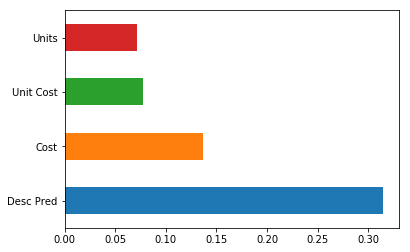

In [109]:
#What do the feature importances look like?
(pd.Series(RF_CV.best_estimator_.feature_importances_, index=X_train.columns).nlargest(4).plot(kind='barh'))

In [110]:
from sklearn.neighbors import KNeighborsClassifier

#Try the KNeighborsClassifier 
KN_clf = KNeighborsClassifier()

parameters = {'n_neighbors': [10],
              'weights': ['distance']
             }

KN_CV = GridSearchCV(KN_clf, parameters, scoring = 'f1_weighted', n_jobs=4, cv = 5, verbose = 5)

KN_CV.fit(X_train, y_train)
print('Best score and parameter combination = ')
print(KN_CV.best_score_)    
print(KN_CV.best_params_) 


KN_y_pred = KN_CV.predict(X_test)

print('accuracy %s' % accuracy_score(KN_y_pred, y_test))
print(classification_report(y_test, KN_y_pred))
rec_scores('KN', KN_y_pred)

#Save model
pickle.dump(KN_CV, open('models/KN_CV.sav', 'wb'))


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:   38.2s remaining:   57.3s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.0min finished


Best score and parameter combination = 
0.6580369783557458
{'n_neighbors': 10, 'weights': 'distance'}
accuracy 0.5159269863994274
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.96      0.96      0.96       112
           2       1.00      0.75      0.86         8
           3       0.88      0.72      0.79        29
           4       0.94      0.84      0.89        19
           5       1.00      0.80      0.89         5
           6       0.47      0.35      0.40        23
           7       0.83      1.00      0.91         5
           8       0.42      0.41      0.42        46
           9       0.73      0.78      0.76       156
          10       0.47      0.55      0.51        29
          11       0.00      0.00      0.00         2
          12       0.45      0.42      0.43        12
          13       0.37      0.27      0.31        51
          14       0.67      0.78      0.72       215
     

/Users/danielkelly/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/danielkelly/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/danielkelly/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/danielkelly/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted 

In [111]:
#Apply SMOTE oversampling to the training dataset to reduce bias introduced by the imbalanced dataset
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train,y_train.ravel())



In [112]:
#How big is the training set now?
len(X_train_res)

380995

In [113]:
#Use the same parameters as the previous RF model.
RF_clf_res = RandomForestClassifier(random_state=42,
                                max_depth = 100,
                                min_samples_split = 2,
                                min_samples_leaf = 2,
                                n_estimators= 100,
                                n_jobs = 4 
                               )



RF_clf_res.fit(X_train_res, y_train_res)


RF_y_pred_res = RF_clf_res.predict(X_test)

print('accuracy %s' % accuracy_score(RF_y_pred_res, y_test))
print(classification_report(y_test, RF_y_pred_res))
rec_scores('RF_res', RF_y_pred_res)


#Save model
pickle.dump(RF_clf_res, open('models/RF_clf_res.sav', 'wb'))


accuracy 0.4890837508947745
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.96      0.96      0.96       112
           2       0.75      0.75      0.75         8
           3       0.91      0.72      0.81        29
           4       0.94      0.84      0.89        19
           5       0.67      0.80      0.73         5
           6       0.32      0.39      0.35        23
           7       1.00      0.80      0.89         5
           8       0.54      0.48      0.51        46
           9       0.75      0.73      0.74       156
          10       0.41      0.55      0.47        29
          11       0.50      0.50      0.50         2
          12       0.43      0.50      0.46        12
          13       0.26      0.35      0.30        51
          14       0.77      0.85      0.81       215
          15       0.61      0.40      0.48       110
          16       0.94      1.00      0.97        16

/Users/danielkelly/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/danielkelly/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/danielkelly/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/danielkelly/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted 

In [114]:
from sklearn.neighbors import KNeighborsClassifier

#Try the KNeighbors Classifier on the enhanced dataset

KN_clf_res = KNeighborsClassifier(n_neighbors=10, weights = 'distance', n_jobs = 4)

KN_clf_res.fit(X_train_res, y_train_res)

KN_y_pred_res = KN_clf_res.predict(X_test)

print('accuracy %s' % accuracy_score(KN_y_pred_res, y_test))
print(classification_report(y_test, KN_y_pred_res))

rec_scores('KN_res', KN_y_pred_res)

pickle.dump(KN_clf_res, open('models/KN_CV_res.sav', 'wb'))

accuracy 0.4858625626342162
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.97      0.96      0.97       112
           2       0.55      0.75      0.63         8
           3       0.78      0.72      0.75        29
           4       1.00      0.89      0.94        19
           5       0.57      0.80      0.67         5
           6       0.37      0.30      0.33        23
           7       0.45      1.00      0.62         5
           8       0.45      0.43      0.44        46
           9       0.69      0.74      0.71       156
          10       0.43      0.52      0.47        29
          11       0.00      0.00      0.00         2
          12       0.35      0.50      0.41        12
          13       0.30      0.27      0.29        51
          14       0.71      0.77      0.74       215
          15       0.47      0.40      0.43       110
          16       0.85      0.69      0.76        16

/Users/danielkelly/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/danielkelly/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/danielkelly/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/danielkelly/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted 

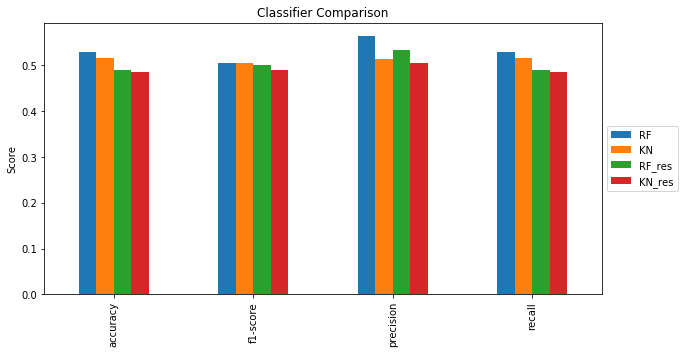

In [115]:
#How do all the classifiers compare:
# RF - Random Forest
# KN - Kneighbors
# RF_res - Random Forest with SMOTE enhanced dataset
# KN_Res - KNeighbors with SMOTE Enhanced Dataset

pd.DataFrame(model_scores).plot(kind='bar', figsize=(10,5))
plt.title('Classifier Comparison')
plt.ylabel('Score')
plt.legend(loc = 'center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [116]:
#Use the Random forest predictions, and reverse the label encoding on it and the actual cost code.
df_output = pd.DataFrame({'Text':X_test_desc ,'Predicted Code':le.inverse_transform(RF_y_pred), 'Actual Code':le.inverse_transform(y_test)})

In [117]:
#Confirm the name_mapping loaded correctly
name_mapping.head()

,Cost Code,Description
0,00-10-17,geotechnical consultant
1,00-61-13,subtrade bonds
2,01-30-12,project manager
3,01-30-14,project coordinator
4,01-30-23,finishing superintendent


In [118]:
#Map the actual cost code to its corresponding description
out = df_output.merge(name_mapping, left_on='Actual Code',right_on='Cost Code')
out.rename(index=str, columns={'Description':'Actual Code Desc.'}, inplace = True)
out.drop(['Cost Code'], axis = 1, inplace = True)
out.head()

,Text,Predicted Code,Actual Code,Actual Code Desc.
0,PST,07-84-10,07-84-10,firestopping trade contract
1,caulking firestop,01-52-23,07-84-10,firestopping trade contract
2,freight in,01-52-23,07-84-10,firestopping trade contract
3,PST,07-84-10,07-84-10,firestopping trade contract
4,PST,07-84-10,07-84-10,firestopping trade contract


In [119]:
#Map the predicted cost code to its corresponding description
out = out.merge(name_mapping, left_on='Predicted Code',right_on='Cost Code')
out.drop(['Cost Code'], axis = 1, inplace=True)
out.rename(index=str, columns={'Description':'Predicted Code Desc.'}, inplace=True)
out.head()

,Text,Predicted Code,Actual Code,Actual Code Desc.,Predicted Code Desc.
0,PST,07-84-10,07-84-10,firestopping trade contract,firestopping trade contract
1,PST,07-84-10,07-84-10,firestopping trade contract,firestopping trade contract
2,PST,07-84-10,07-84-10,firestopping trade contract,firestopping trade contract
3,firestopping pipes-INV#8770,07-84-10,07-84-10,firestopping trade contract,firestopping trade contract
4,Vestibules P4 P3 P2,07-84-10,07-84-10,firestopping trade contract,firestopping trade contract


In [120]:
#Re-order columns for ease of reading
cols = ['Text', 'Predicted Code','Predicted Code Desc.', 'Actual Code', 'Actual Code Desc.']
out = out[cols]

In [121]:
#Check a random sample of codes.
out.sample(n=5)

,Text,Predicted Code,Predicted Code Desc.,Actual Code,Actual Code Desc.
4427,Polarcon Accelerating - Bronze,03-31-41,concrete material - below-grade verticals,03-31-41,concrete material - below-grade verticals
5323,Offix Marker whiteb. chi.ass.,01-52-22,field office supplies,01-52-22,field office supplies
93,306860,01-52-23,field supplies,01-52-23,field supplies
5179,Fuel Surcharge-Per Load,03-31-42,concrete materials - below-grade horizontals,03-31-40,concrete material - footings
933,FREIGHT IN,01-52-23,field supplies,01-54-24,temporary stairway
